# EM example: Gaussian Mixture Models

## Fig 6.6

In [1]:
"""
EM example: Gaussian Mixture Models
-----------------------------------
Figure 6.6

A two-dimensional mixture of Gaussians for the stellar metallicity data. The
left panel shows the number density of stars as a function of two measures of
their chemical composition: metallicity ([Fe/H]) and alpha-element abundance
([alpha/Fe]). The right panel shows the density estimated using mixtures of
Gaussians together with the positions and covariances (2-sigma levels) of
those Gaussians. The center panel compares the information criteria AIC
and BIC (see Sections 4.3.2 and 5.4.3).
"""

'\nEM example: Gaussian Mixture Models\n-----------------------------------\nFigure 6.6\n\nA two-dimensional mixture of Gaussians for the stellar metallicity data. The\nleft panel shows the number density of stars as a function of two measures of\ntheir chemical composition: metallicity ([Fe/H]) and alpha-element abundance\n([alpha/Fe]). The right panel shows the density estimated using mixtures of\nGaussians together with the positions and covariances (2-sigma levels) of\nthose Gaussians. The center panel compares the information criteria AIC\nand BIC (see Sections 4.3.2 and 5.4.3).\n'

In [2]:
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.utils.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse


/Users/dagoret/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [3]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

In [4]:
N=10
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [5]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [6]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

# Get the Segue Stellar Parameters Pipeline data

In [7]:
#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]


In [8]:
X.shape

(15226, 2)

Text(0, 0.5, 'X[1]')

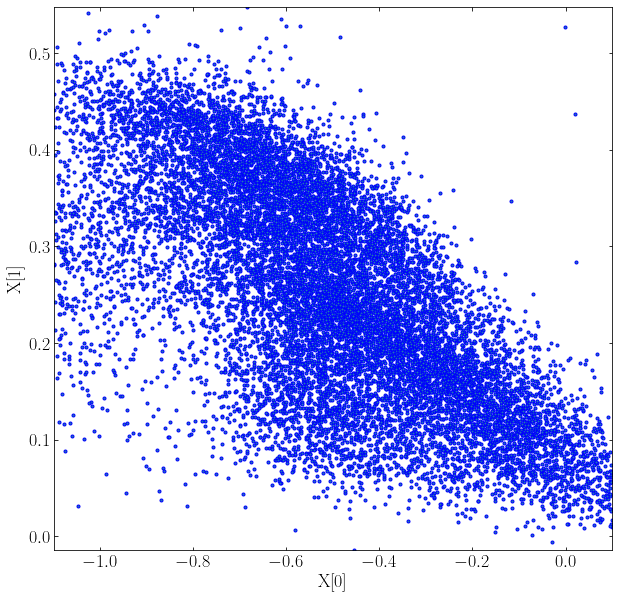

In [9]:
fig = plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111)
ax.scatter(X[:,0],X[:,1],marker='.')
ax.set_xlabel("X[0]")
ax.set_ylabel("X[1]")

# Compute GaussianMixture models & AIC/BIC

In [10]:
#------------------------------------------------------------
# Compute GaussianMixture models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  5


# compute 2D density

In [11]:
#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------

# Plot the results

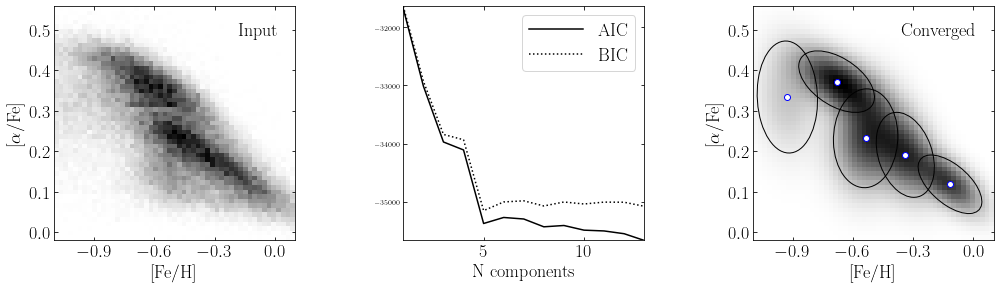

In [12]:
# Plot the results
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()
